Train Data Count: 6992
Found 5593 validated image filenames.
Found 1399 validated image filenames.
Epoch 1/10


C:\Users\seoyu\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - loss: 0.0691 - mae: 0.1318 - mse: 0.0691 - val_loss: 660.8956 - val_mae: 12.7670 - val_mse: 660.8956
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - loss: 0.0474 - mae: 0.1024 - mse: 0.0474 - val_loss: 173330.9219 - val_mae: 181.5416 - val_mse: 173330.9219
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - loss: 0.0471 - mae: 0.1017 - mse: 0.0471 - val_loss: 4494.2021 - val_mae: 23.6208 - val_mse: 4494.2021
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - loss: 0.0465 - mae: 0.1004 - mse: 0.0465 - val_loss: 8133.2808 - val_mae: 22.8607 - val_mse: 8133.2808
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 365s 2s/step - loss: 0.0462 - mae: 0.0997 - mse: 0.0462 - val_loss: 0.0497 - val_mae: 0.1103 - val_mse: 0.0497
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - loss: 0.0457 - mae: 0.0995 - mse: 0.0457 - val_loss: 0.0540 - val_mae: 0.1116 - val_mse: 0.0540
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - loss: 0.0458 - mae:

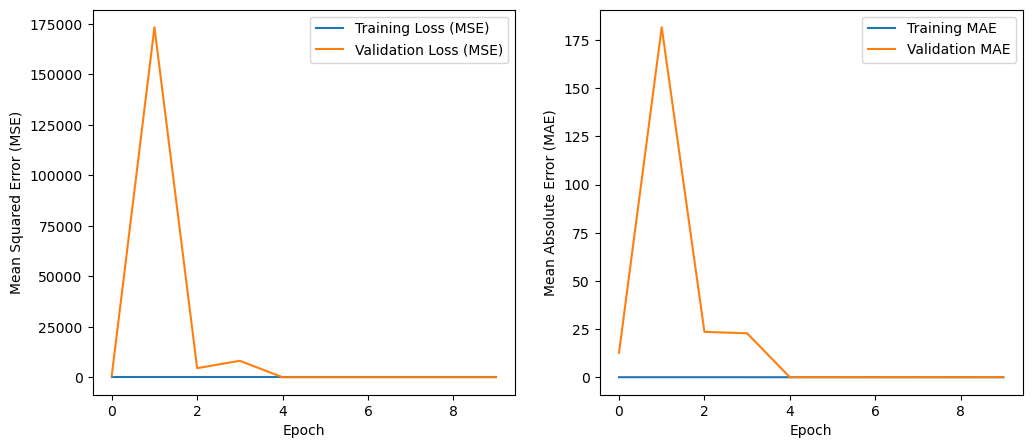

In [4]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 데이터 경로 설정
data_dir = os.path.expanduser('/Users/seoyu/Desktop/open')
train_dir = os.path.join(data_dir, 'train')
train_csv_path = os.path.join(data_dir, 'train.csv')

# 데이터 불러오기
train_df = pd.read_csv(train_csv_path)

# 이미지 경로 수정 (train_dir와 결합하여 절대 경로로 변경)
train_df['path'] = train_df['path'].apply(lambda x: os.path.join(train_dir, os.path.basename(x)))

# 유효한 경로가 아닌 경우 제거
train_df = train_df[train_df['path'].apply(lambda x: os.path.isfile(x))]

# 데이터 수 확인
print(f"Train Data Count: {len(train_df)}")

# 데이터가 충분한지 확인
if len(train_df) == 0:
    raise ValueError("train_df가 비어 있습니다. 데이터 경로 또는 CSV 파일을 확인하세요.")

# train_df를 학습 및 검증 데이터로 분할
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# EfficientNetB0 모델 설정 (회귀용)
def build_model():
    base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(3467, activation='linear')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

model = build_model()

# 모델 컴파일 (MSE와 MAE를 성능 지표로 설정)
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

# 데이터 전처리 및 제너레이터 설정
datagen = ImageDataGenerator(rescale=1.0/255.0)

# 제너레이터 생성
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col=train_df.columns[2:].tolist(),
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'  # 변경: None에서 raw로 수정하여 회귀 문제에 적합하게 설정
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col=val_df.columns[2:].tolist(),
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'  # 변경: None에서 raw로 수정
)

# 모델 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10  # 필요에 따라 에포크 수 조절
)

# 학습 결과 시각화 (MSE와 MAE)
plt.figure(figsize=(12, 5))

# val_loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history.get('loss', []), label='Training Loss (MSE)')
plt.plot(history.history.get('val_loss', []), label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()

# val_mae 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history.get('mae', []), label='Training MAE')
plt.plot(history.history.get('val_mae', []), label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()

plt.show()

In [7]:
import numpy as np

# 테스트 이미지에 대한 경로가 있는 데이터프레임 불러오기 (예시로 test.csv 사용)
test_csv_path = os.path.join(data_dir, 'test.csv')
test_df = pd.read_csv(test_csv_path)

# 이미지 경로 수정 (절대 경로로 변경)
test_df['path'] = test_df['path'].apply(lambda x: os.path.join(data_dir, 'test', os.path.basename(x)))

# 테스트 제너레이터 생성
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,  # 테스트 데이터에는 레이블이 없으므로 None 사용
    shuffle=False
)

# 모델을 사용하여 예측 수행
predictions = model.predict(test_generator)

# 결과를 DataFrame으로 변환
submission_df = pd.DataFrame(predictions, columns=train_df.columns[2:].tolist())

# ID 열 추가
submission_df.insert(0, 'ID', test_df['ID'])

# CSV 파일로 저장
submission_csv_path = os.path.join(data_dir, 'submission.csv')
submission_df.to_csv(submission_csv_path, index=False)

print(f"예측 결과가 CSV 파일로 저장되었습니다: {submission_csv_path}")

Found 2277 validated image filenames.


C:\Users\seoyu\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step
예측 결과가 CSV 파일로 저장되었습니다: /Users/seoyu/Desktop/open\submission.csv
